In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import datetime
import importlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import create_and_plot as cp

`Load Dataframe`

In [2]:
df = pd.read_csv("FINAL_STOCKS.csv")
df.tail()

,date,max_price,min_price,closing,opening,change_pctg,volume,value,n_deals,stock
16530,2014-01-15,0.80,0.79,0.79,0.80,1.27,"1,958","2,188.15",5,Wassel
16531,2014-01-14,0.79,0.79,0.80,0.79,-1.25,480,534.84,4,Wassel
16532,2014-01-12,0.80,0.80,0.82,0.80,-2.44,404,455.85,3,Wassel
16533,2014-01-08,0.82,0.82,0.81,0.82,1.23,200,231.31,2,Wassel
16534,2014-01-06,0.81,0.81,0.85,0.81,-4.71,136,155.37,1,Wassel


`Data summary`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16535 entries, 0 to 16534
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         16535 non-null  object 
 1   max_price    16535 non-null  float64
 2   min_price    16535 non-null  float64
 3   closing      16535 non-null  float64
 4   opening      16535 non-null  float64
 5   change_pctg  16535 non-null  float64
 6   volume       16535 non-null  object 
 7   value        16535 non-null  object 
 8   n_deals      16535 non-null  int64  
 9   stock        16535 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.3+ MB


In [4]:
df.isna().sum()

date           0
max_price      0
min_price      0
closing        0
opening        0
change_pctg    0
volume         0
value          0
n_deals        0
stock          0
dtype: int64

In [5]:
df.describe()

,max_price,min_price,closing,opening,change_pctg,n_deals
count,16535.000000,16535.000000,16535.000000,16535.000000,16535.000000,16535.000000
mean,1.999178,1.980512,1.994600,1.994836,0.026739,8.666526
std,1.072794,1.066849,1.071422,1.071631,1.792375,11.451771
min,0.290000,0.290000,0.290000,0.290000,-47.640000,1.000000
25%,1.110000,1.100000,1.110000,1.110000,-0.540000,2.000000
50%,1.830000,1.810000,1.830000,1.830000,0.000000,5.000000
75%,2.530000,2.500000,2.520000,2.520000,0.520000,11.000000
max,7.000000,6.800000,6.840000,6.840000,31.940000,173.000000


`Reorder columns`

In [6]:
df.rename(columns={'max_price':'highest', 'min_price':'lowest'}, inplace=True)
df.columns

Index(['date', 'highest', 'lowest', 'closing', 'opening', 'change_pctg',
       'volume', 'value', 'n_deals', 'stock'],
      dtype='object')

In [7]:
desired_order = ['stock', 'date'] + [ col for col in df.columns if col not in ['stock', 'date'] ]
desired_order

['stock',
 'date',
 'highest',
 'lowest',
 'closing',
 'opening',
 'change_pctg',
 'volume',
 'value',
 'n_deals']

In [8]:
df = df[desired_order]
df.tail()

,stock,date,highest,lowest,closing,opening,change_pctg,volume,value,n_deals
16530,Wassel,2014-01-15,0.80,0.79,0.79,0.80,1.27,"1,958","2,188.15",5
16531,Wassel,2014-01-14,0.79,0.79,0.80,0.79,-1.25,480,534.84,4
16532,Wassel,2014-01-12,0.80,0.80,0.82,0.80,-2.44,404,455.85,3
16533,Wassel,2014-01-08,0.82,0.82,0.81,0.82,1.23,200,231.31,2
16534,Wassel,2014-01-06,0.81,0.81,0.85,0.81,-4.71,136,155.37,1


# `1. EDA && Feature Engineering & Preprocessing`

## 1.1 `Standard EDA and Preprocessing`

`Datize the date column`

In [9]:
from preprocess import datize_date

In [10]:
df = datize_date(df)
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`See which stocks ahs the largest volume and #of trades`

In [11]:
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`Numerize the (value, volume) columns`

In [12]:
import preprocess
importlib.reload(preprocess)
from preprocess import numerize_value_and_volume

In [13]:
df = numerize_value_and_volume(df)
df[['value','volume']].dtypes

value     float64
volume    float64
dtype: object

In [14]:
df.groupby('stock')['volume'].sum().sort_values(ascending=False).head().to_frame()

,volume
stock,
BoP,233303637.0
apic,217731363.0
Isbk,113171223.0
oreedo,70735761.0
AIB,43606684.0


In [15]:
df.groupby('stock')['n_deals'].sum().sort_values(ascending=False).head().to_frame()

,n_deals
stock,
BoP,44264
apic,33722
oreedo,26076
Isbk,17927
AIB,6694


`Set stock, date as the index`

In [16]:
df.set_index('stock', inplace=True)
df.index.unique()

Index(['AIB', 'apic', 'BoP', 'bpc', 'GUI', 'Isbk', 'jph', 'oreedo', 'trust',
       'Wassel'],
      dtype='object', name='stock')

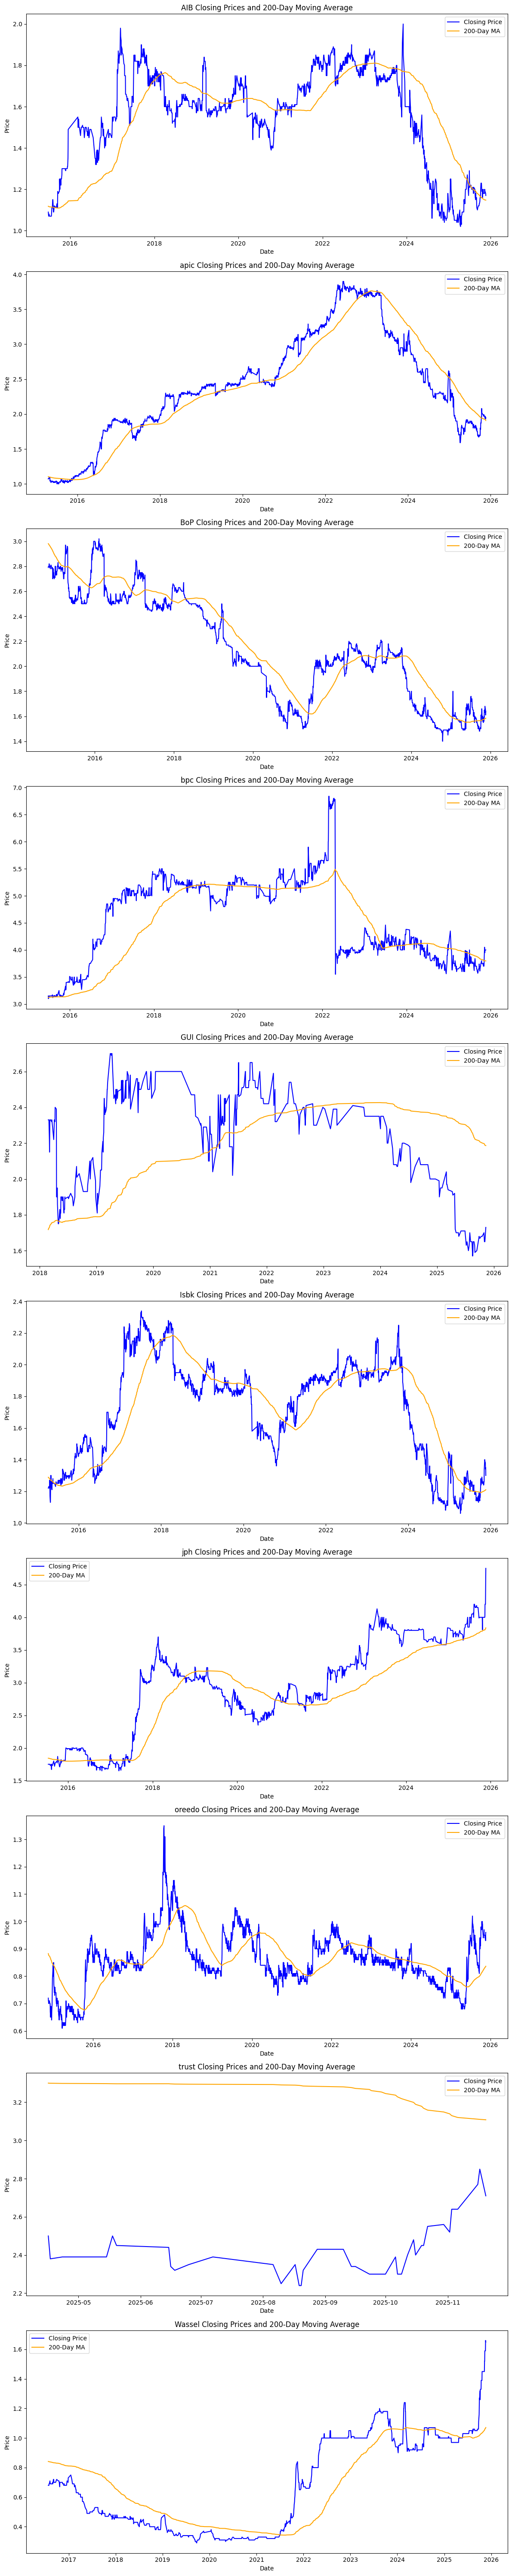

In [17]:
import visualize
importlib.reload(visualize)
from visualize import plot_stocks_closing_200MA
plot_stocks_closing_200MA(df)

`Working with individual stocks`

In [18]:
importlib.reload(utils)
from utils import take_stock

            highest  lowest  closing  opening  change_pctg   volume  \
date                                                                  
2014-01-02     3.20    3.19     3.20     3.19        -0.31  25566.0   
2014-01-05     3.17    3.12     3.19     3.13        -1.88  24331.0   
2014-01-06     3.15    3.12     3.13     3.13         0.00  94225.0   
2014-01-08     3.17    3.13     3.13     3.17         1.28  44673.0   
2014-01-09     3.19    3.17     3.17     3.19         0.63  29244.0   

                value  n_deals  
date                            
2014-01-02   81800.50       19  
2014-01-05   76502.03       28  
2014-01-06  295711.69       31  
2014-01-08  141304.63       19  
2014-01-09   93072.42       32  


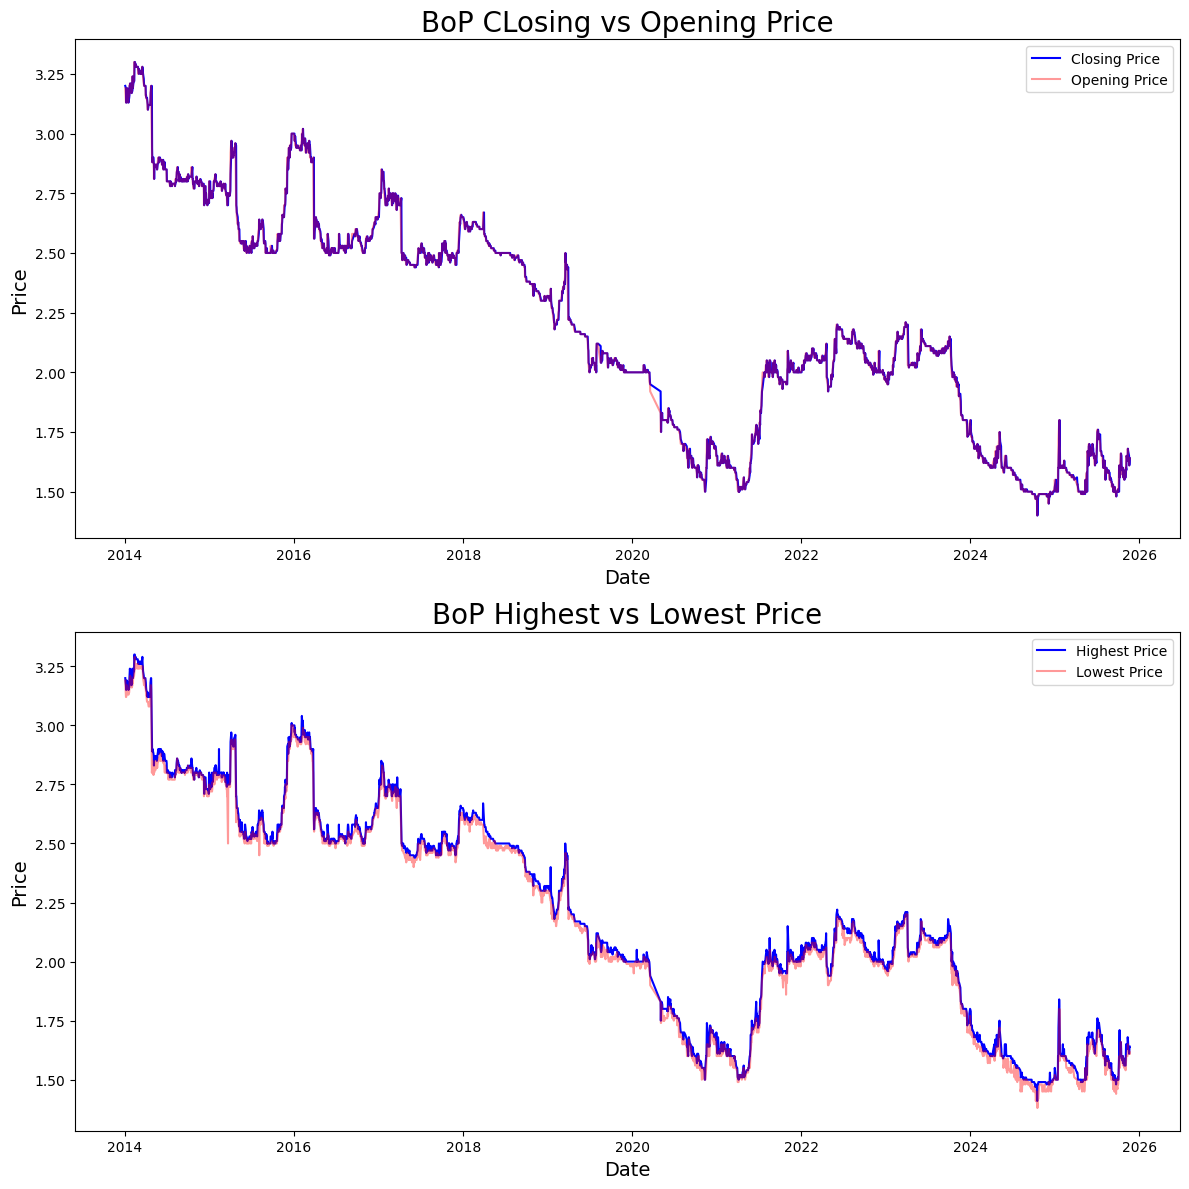

In [19]:
bop = take_stock(df, 'BoP')

`As we can see from the first graph we cacn tell that opening and closing prices are almost always identical indicating the low volatility in PEX in general`

----------------------------------

`The initial model we will try is to predict the direction of the movement for stock`

## 1.2 `Creating informative variables`

`First of all create the movemetn direction target variable`

`Create 1 Day Classification target variable with concern for predicting up movements`

### 1.2.1 `Create The Target Variable`

In [20]:
importlib.reload(utils)
from utils import create_and_plot as cp

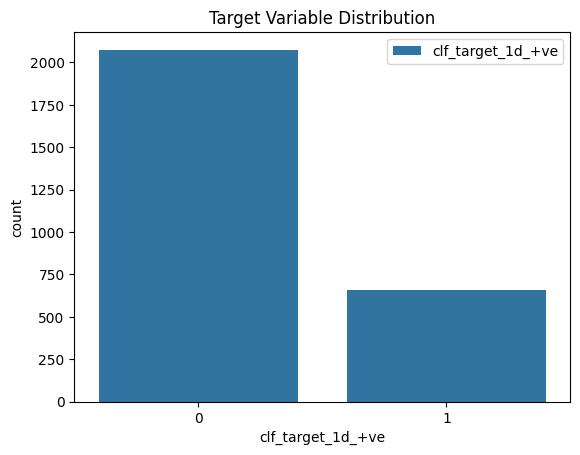

Variables with Strong Correlation with variable clf_target_1d_+ve (> 0.25) :  [('change_pctg', 0.592865615803275)]


In [21]:
bop = cp(bop, "target")

### 1.2.2 `Create Time Since Last Trade Variable`

In [22]:
importlib.reload(utils)
from utils import create_and_plot as cp

Maximum idle time between trades is: 45 days.


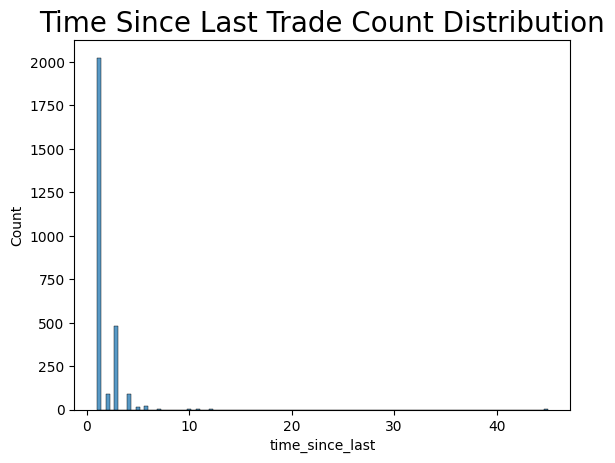

No Strong Pearson Correlations.


In [23]:
bop = cp(bop, "time_since_last")

### 1.2.3 `Create Moving Averages`

In [24]:
importlib.reload(utils)
from utils import create_and_plot as cp

Moving Average for 20 Days Created.
Moving Average for 50 Days Created.
Moving Average for 200 Days Created.
MA Ratio Created


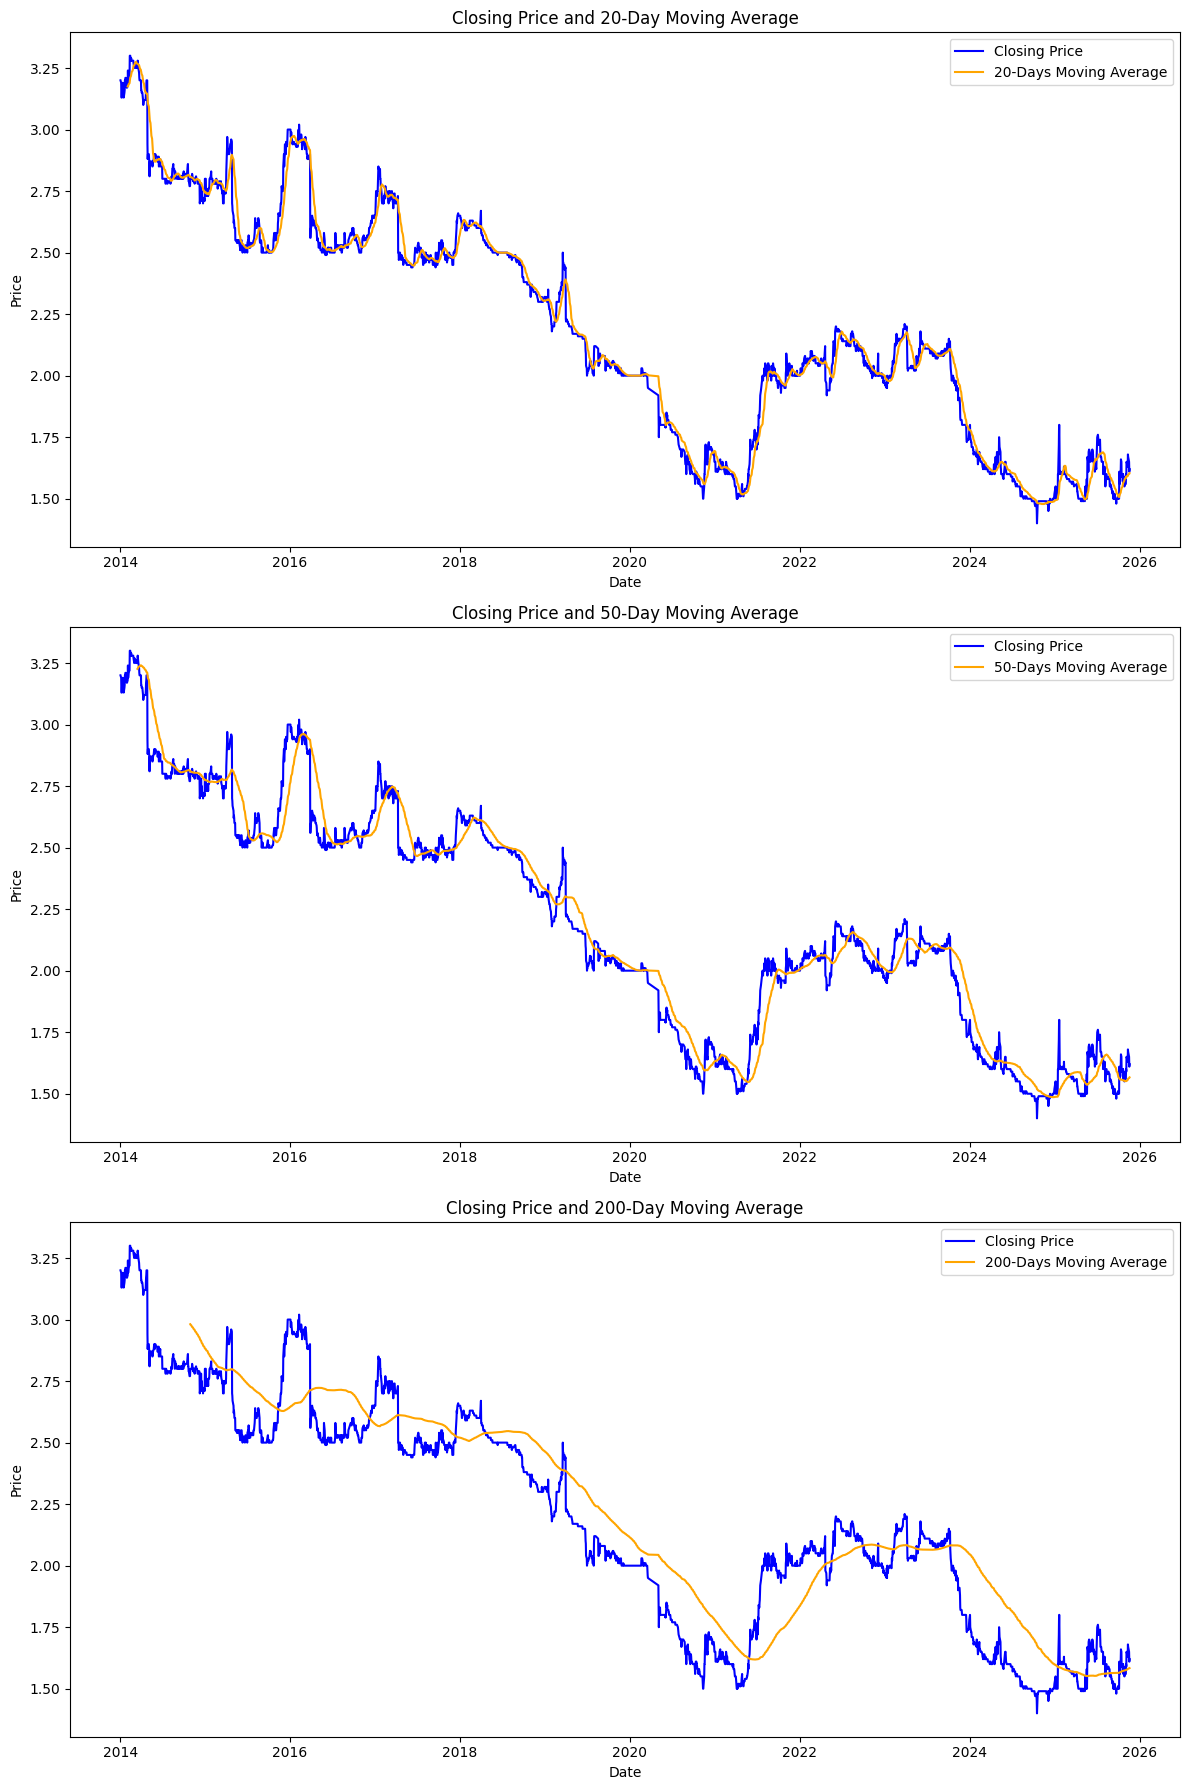

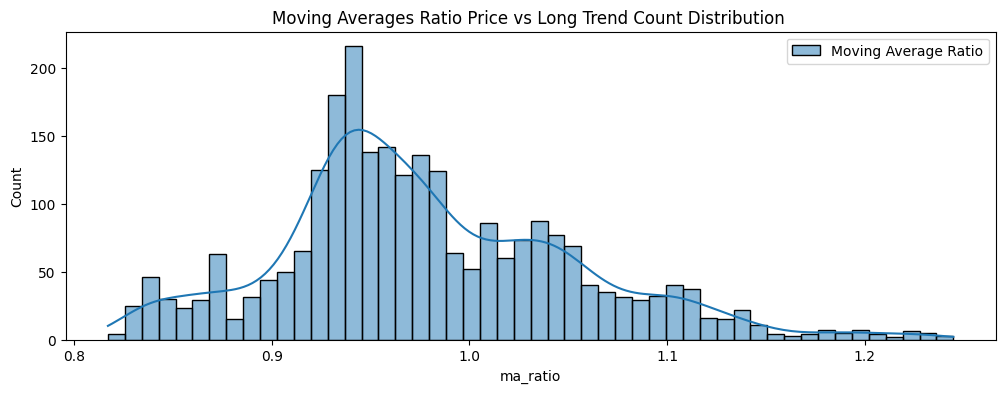

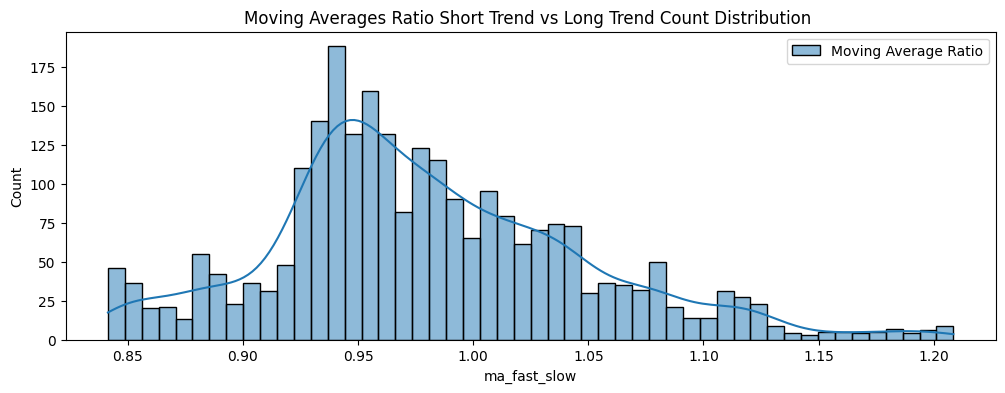

           20_MA     50_MA    200_MA
20_MA   1.000000  0.992926  0.941359
50_MA   0.992926  1.000000  0.958654
200_MA  0.941359  0.958654  1.000000
Variables with Strong Correlation with variable 20_MA (> 0.25) :  [('highest', 0.9919806150591076), ('lowest', 0.9919495385649161), ('closing', 0.9932790936145349), ('opening', 0.9921758857712485), ('n_deals', 0.2772051542715414), ('ma_fast_slow', 0.276939496177473)]


In [25]:
bop = cp(bop, "moving_averages")

`This chart makes total sense since PEX ahs very low volatility which is why even the 20MA almost perfectly hugs the closign price`

`MA won't reveal much information and alone is not enough for ML model to revela hideen patterns we need to create more features`

### 1.2.4 `Create Range Variable`

In [26]:
importlib.reload(utils)
from utils import create_and_plot as cp

Variables with Strong Correlation with variable range (> 0.25) :  [('n_deals', 0.3970993821851938)]


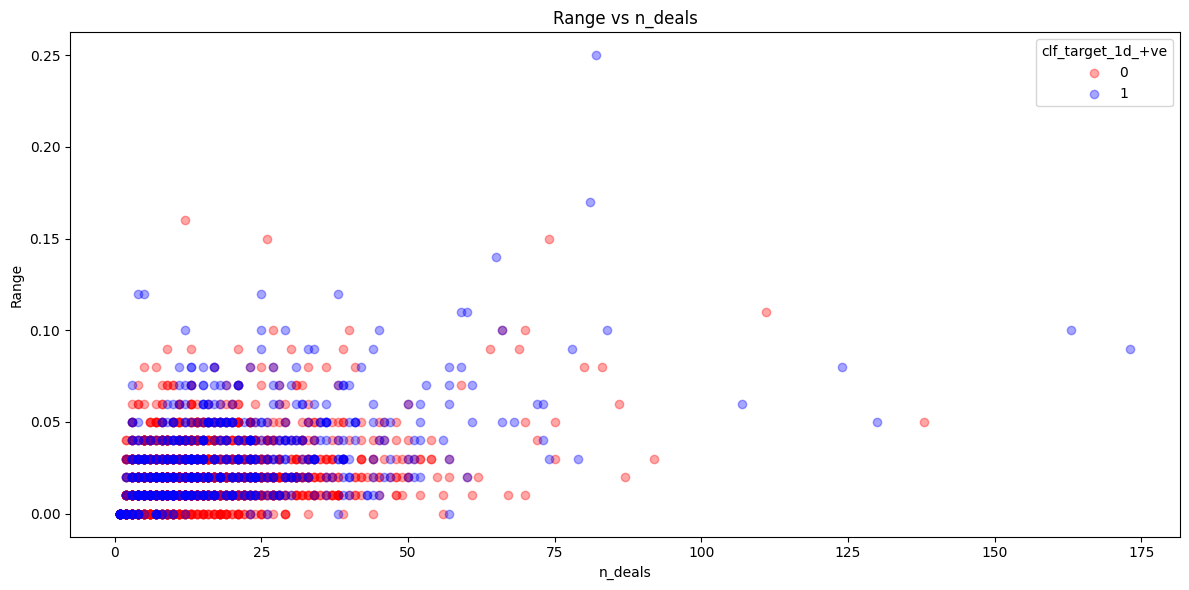

In [27]:
bop = cp(bop, "target", plot=False, corr=True)
bop = cp(bop, "range")

### 1.2.5 `Crate Daily Returns Variables`

1-Day Return Variable Created.
3-Day Return Variable Created.
5-Day Return Variable Created.


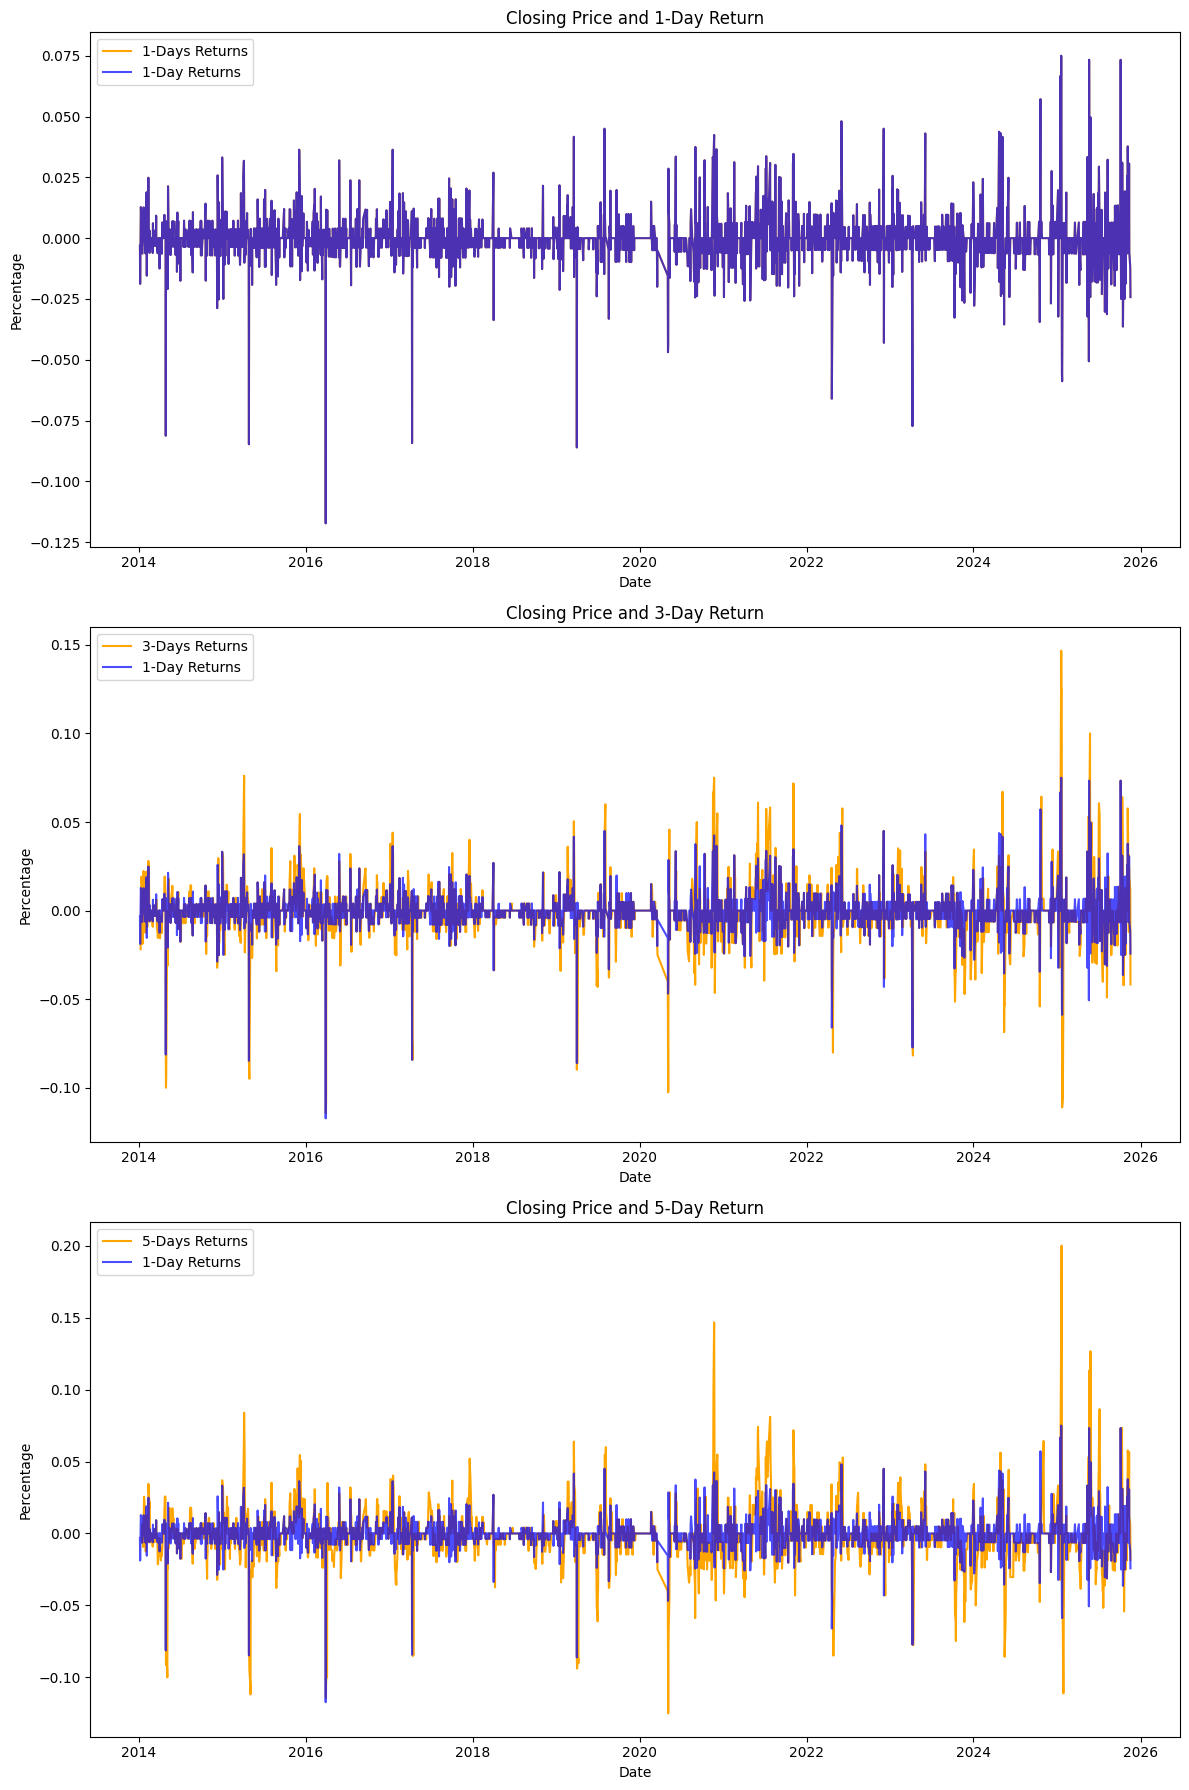

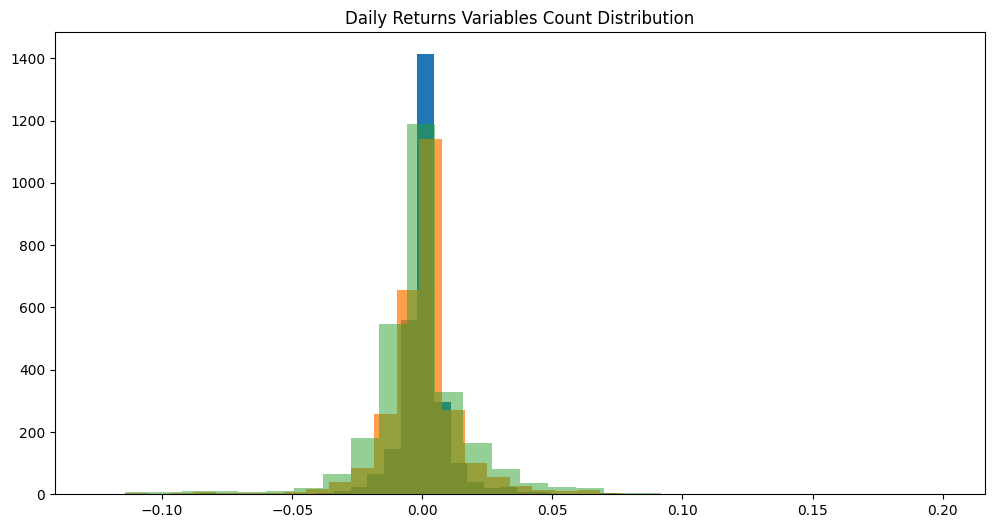

          r1        r3        r5
r1  1.000000  0.562517  0.443446
r3  0.562517  1.000000  0.761972
r5  0.443446  0.761972  1.000000
No Strong Pearson Correlations.


In [28]:
bop = cp(bop, "returns")

`As we can see the returns distibution has fatter tails on the longer run which makes total sense for a low volatility market`

### 1.2.6 `volatility X days`

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.


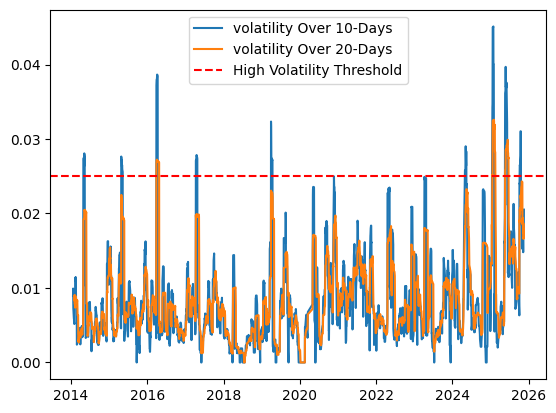

                volatility_10d  volatility_20d
volatility_10d         1.00000         0.76246
volatility_20d         0.76246         1.00000
Variables with Strong Correlation with variable volatility_10d (> 0.25) :  [('200_MA', -0.26876817282042914)]


In [29]:
bop = cp(bop, "volatility")

`For reference comparing BoP with oreedo who is riskier`

In [30]:
from utils import take_stock

In [31]:
ord = take_stock(df, 'oreedo', plot=False)

In [32]:
importlib.reload(utils)
from utils import create_and_plot as cp

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.


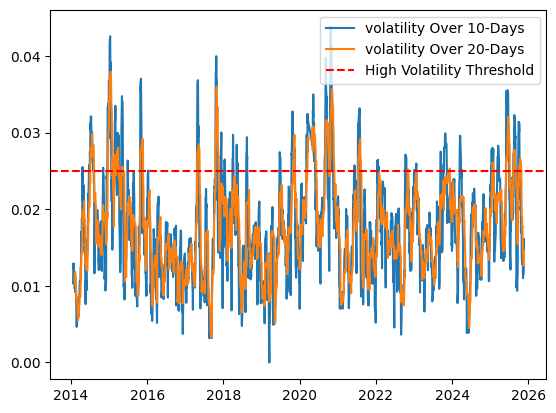

                volatility_10d  volatility_20d
volatility_10d        1.000000        0.807378
volatility_20d        0.807378        1.000000


In [33]:
ord = cp(ord, "returns", plot=False, corr=False)
ord = cp(ord, "volatility", corr=False)

### 1.2.7 `RSI`

In [34]:
import utils
importlib.reload(utils)
from utils import create_and_plot as cp

RSI for 7- days created.
RSI for 14- days created.


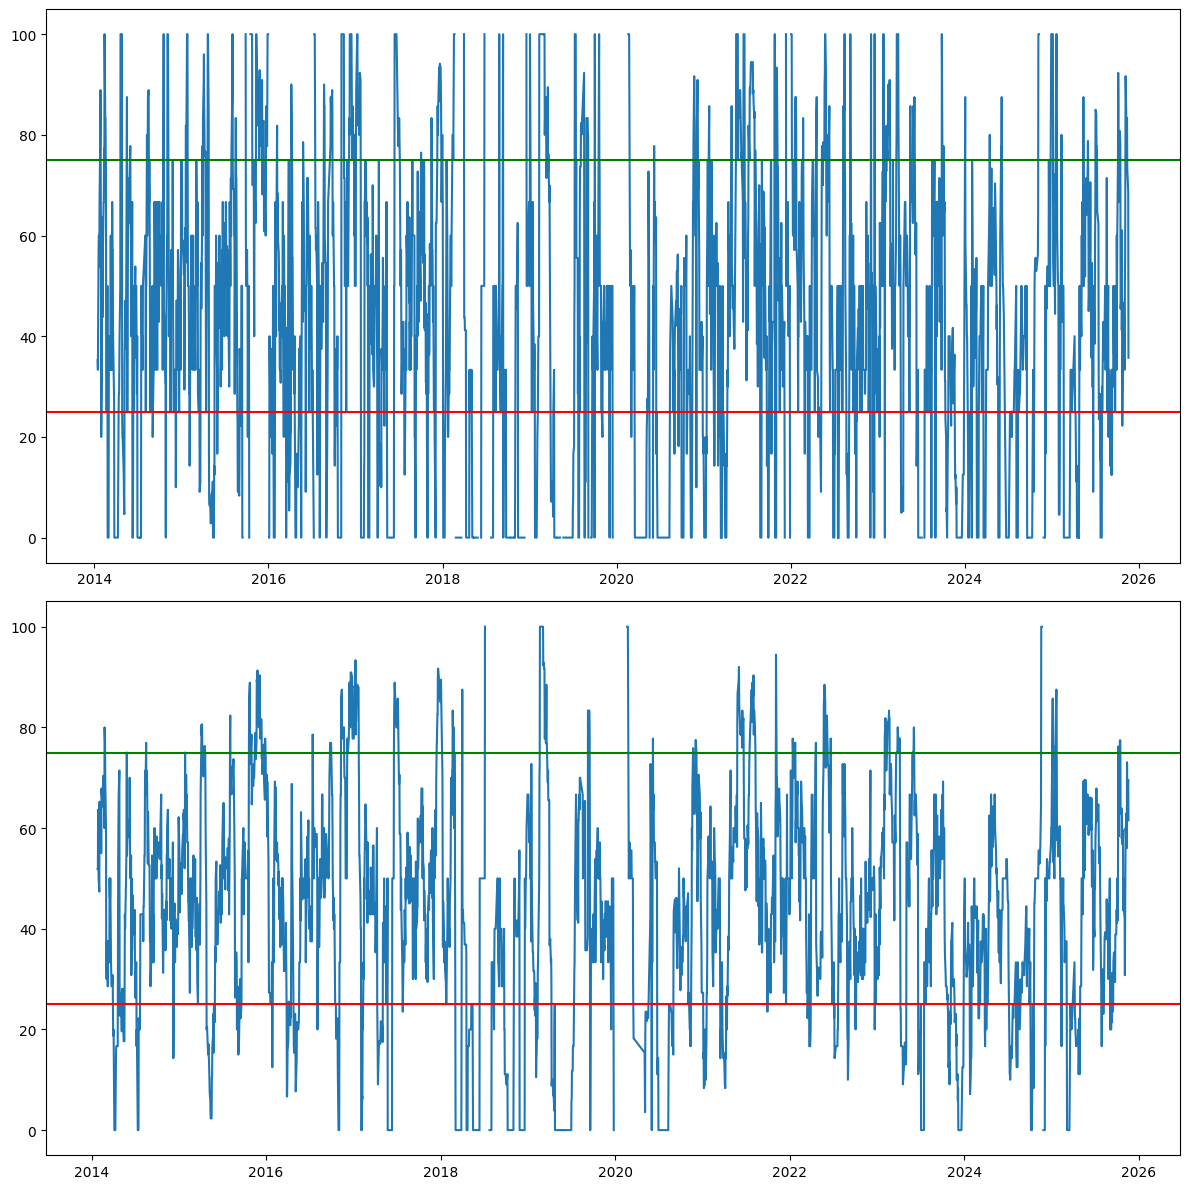

           rsi_7    rsi_14
rsi_7   1.000000  0.721209
rsi_14  0.721209  1.000000
Variables with Strong Correlation with variable rsi_7 (> 0.25) :  [('ma_ratio', 0.2885509696199181), ('r1', 0.2950910720842484), ('r3', 0.46581939398521083), ('r5', 0.5799303987555876)]


In [35]:
bop = cp(bop, "rsi", plot=True)

### 1.2.8 `Liquidity features`

In [36]:
importlib.reload(utils)
from utils import create_and_plot as cp

Liquidity Features (volume_z) and (n_deals_change) Created.


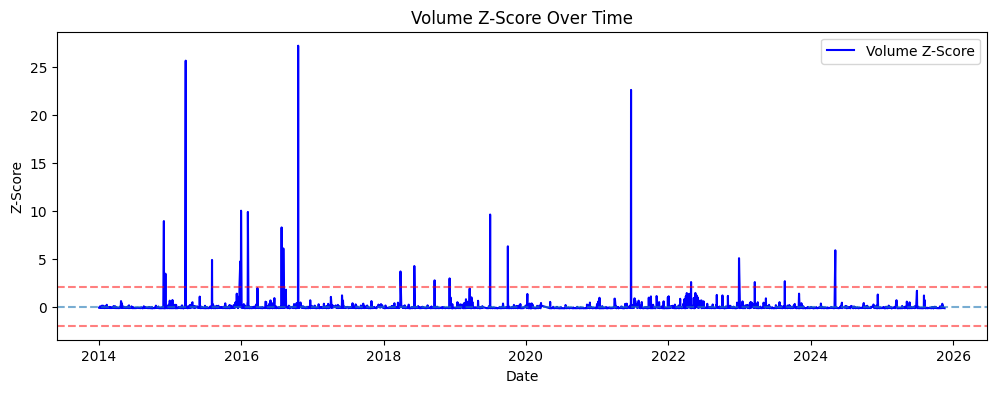

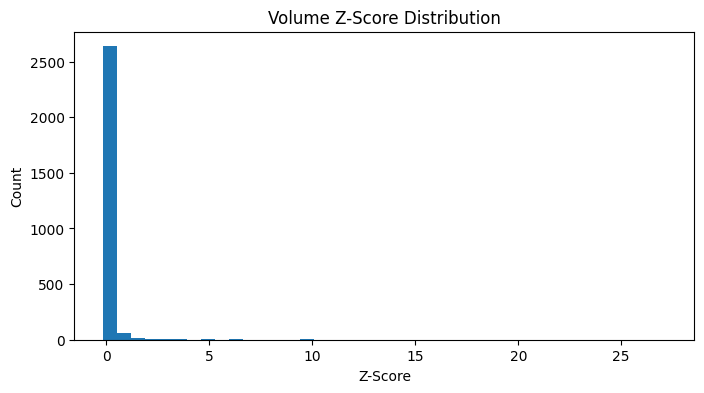

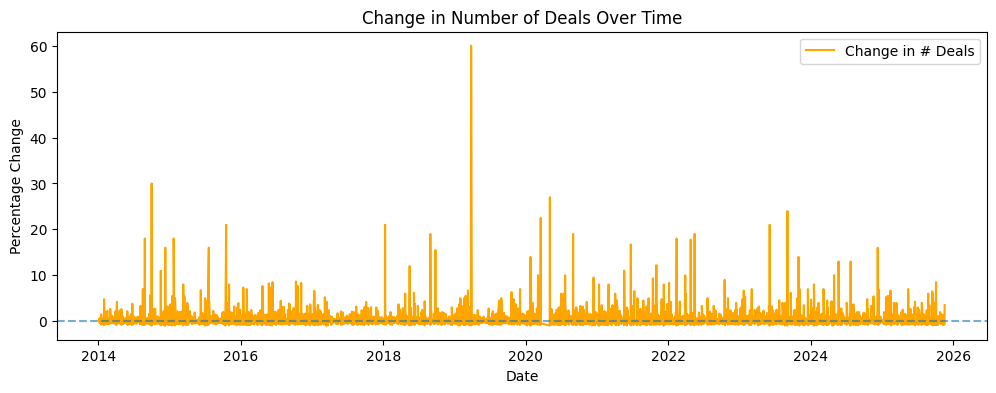

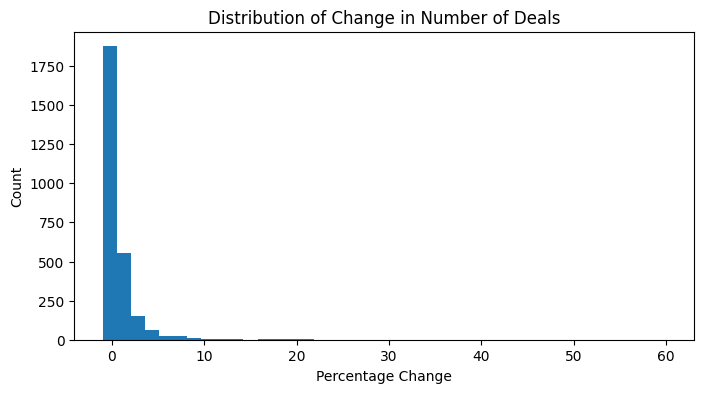

In [37]:
bop = cp(bop, "liquidity")

---------------------------------------

In [38]:
importlib.reload(utils)
from utils import normalize_range, add_temporal_features
from utils import create_and_plot as cp

In [39]:
bop = normalize_range(bop)

Normalized Range Created
               range  range_norm
range       1.000000    0.945146
range_norm  0.945146    1.000000
Due to almost perfect correlation range feature dropped.


### 1.2.9 `Temporal Features`

In [40]:
bop = add_temporal_features(bop)

Temporal Features Created.


### 1.2.10 `MACD`

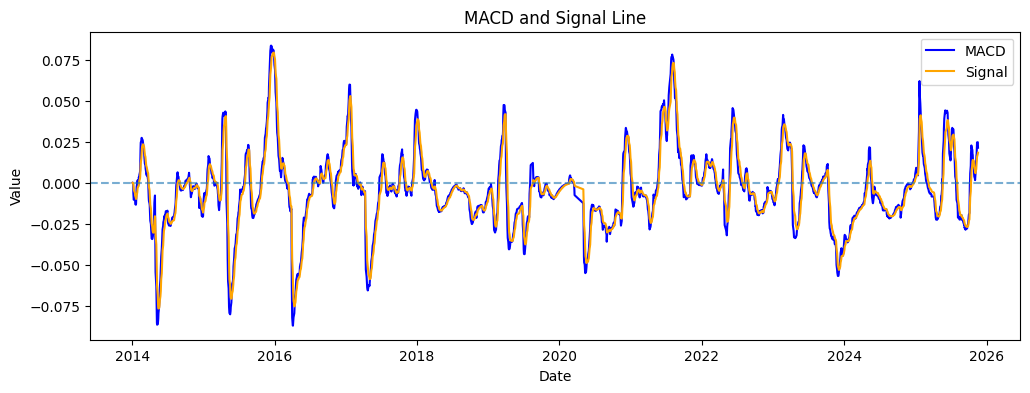

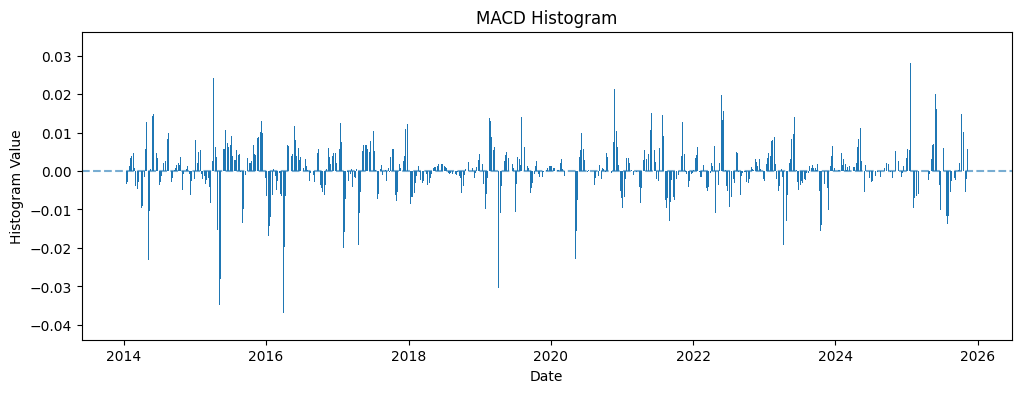

In [41]:
bop = cp(bop, "macd")

### 1.2.11 `Stochastic`

In [42]:
importlib.reload(utils)
from utils import create_and_plot as cp

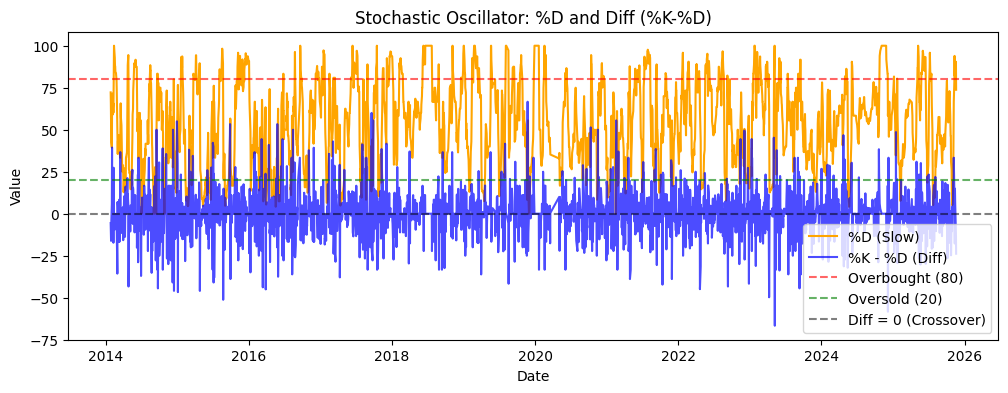

In [43]:
bop = cp(bop, "stochastic")

### 1.3.0 `After training the model we found out that there is a leakge in the data where change pctg was calculated based on tomorrow's price isntead of today's`

In [44]:
from create_features import fix_stock_change_pctg_leakge
bop = fix_stock_change_pctg_leakge(bop, 'BoP')

## 1.3 `Dropping redundant/highly multi cllinearity features`

In [45]:
corr = bop.corr()
pairs = [
    (i, j, corr.loc[i, j])
    for idx, i in enumerate(corr.columns)
    for j in corr.columns[idx + 1:]
    if abs(corr.loc[i, j]) > 0.85
]
    

In [46]:
pairs

[('highest', 'lowest', np.float64(0.9990559922811156)),
 ('highest', 'closing', np.float64(0.9988500484542382)),
 ('highest', 'opening', np.float64(0.9997520280729839)),
 ('highest', '20_MA', np.float64(0.9919766078418625)),
 ('highest', '50_MA', np.float64(0.9793744803939513)),
 ('highest', '200_MA', np.float64(0.9273834950417738)),
 ('lowest', 'closing', np.float64(0.9985989395491028)),
 ('lowest', 'opening', np.float64(0.9991087628581339)),
 ('lowest', '20_MA', np.float64(0.9919458534782256)),
 ('lowest', '50_MA', np.float64(0.9793493896052592)),
 ('lowest', '200_MA', np.float64(0.9278910596394996)),
 ('closing', 'opening', np.float64(0.9988029294547078)),
 ('closing', '20_MA', np.float64(0.9932748866097996)),
 ('closing', '50_MA', np.float64(0.980956466979782)),
 ('closing', '200_MA', np.float64(0.9289191072706876)),
 ('opening', '20_MA', np.float64(0.9921722429716583)),
 ('opening', '50_MA', np.float64(0.9797622292730859)),
 ('opening', '200_MA', np.float64(0.9279692542905585)),
 

In [47]:
bop.drop(columns=['opening', 'highest', 'lowest', '20_MA', '50_MA', '200_MA', 'volume', 'value'], inplace=True)

## 1.4 `Check for  noisy, missy (either logical or physical), inconsistent, and duplicated Data.`

In [48]:
bop.duplicated().sum()

np.int64(0)

In [49]:
bop.isna().sum()

closing                  0
n_deals                  0
clf_target_1d_+ve        0
time_since_last          1
ma_ratio               199
ma_fast_slow           199
r1                       1
r3                       3
r5                       5
volatility_10d          10
volatility_20d          20
rsi_7                  160
rsi_14                  65
volume_z                 0
n_deals_change           1
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                 15
stoch_diff              15
change_pctg              1
dtype: int64

In [50]:
bop[199:].isna().sum()

closing                  0
n_deals                  0
clf_target_1d_+ve        0
time_since_last          0
ma_ratio                 0
ma_fast_slow             0
r1                       0
r3                       0
r5                       0
volatility_10d           0
volatility_20d           0
rsi_7                  152
rsi_14                  51
volume_z                 0
n_deals_change           0
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                  0
stoch_diff               0
change_pctg              0
dtype: int64

In [51]:
bop.describe()

,closing,n_deals,clf_target_1d_+ve,time_since_last,ma_ratio,ma_fast_slow,r1,r3,r5,volatility_10d,...,volume_z,n_deals_change,range_norm,day_of_week,first_week_of_month,macd,macd_hist,stoch_d,stoch_diff,change_pctg
count,2731.000000,2731.000000,2731.000000,2730.000000,2532.000000,2532.000000,2730.000000,2728.000000,2726.000000,2721.000000,...,2731.000000,2730.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2716.000000,2716.000000,2730.000000
mean,2.226979,16.203955,0.239839,1.589011,0.978076,0.979727,-0.000199,-0.000582,-0.000966,0.008006,...,0.000000,0.655203,0.010975,2.376053,0.226657,-0.004131,0.000027,53.800206,-0.005698,-0.019860
std,0.453706,14.087994,0.427063,1.388704,0.074992,0.067853,0.010263,0.016807,0.021443,0.006523,...,1.000000,2.578209,0.010074,2.055885,0.418745,0.023988,0.006959,24.792938,13.424747,1.026326
min,1.400000,1.000000,0.000000,1.000000,0.817082,0.841376,-0.117241,-0.114187,-0.125000,0.000000,...,-0.180552,-0.987500,0.000000,0.000000,0.000000,-0.087326,-0.040208,0.000000,-66.666667,-11.724138
25%,1.950000,7.000000,0.000000,1.000000,0.932092,0.937559,-0.003953,-0.006061,-0.008032,0.003931,...,-0.160351,-0.437500,0.004348,1.000000,0.000000,-0.016819,-0.002816,34.722222,-6.666667,-0.395257
50%,2.150000,13.000000,0.000000,1.000000,0.964635,0.968803,0.000000,0.000000,0.000000,0.006089,...,-0.131436,0.000000,0.008065,2.000000,0.000000,-0.004336,0.000381,54.516317,0.000000,0.000000
75%,2.550000,21.000000,0.000000,2.000000,1.026728,1.019913,0.000000,0.004032,0.004950,0.010112,...,-0.062463,0.833333,0.014706,3.000000,0.000000,0.006060,0.003472,73.611111,6.060606,0.000000
max,3.300000,173.000000,1.000000,45.000000,1.244914,1.208514,0.075000,0.146667,0.200000,0.045107,...,27.183335,60.000000,0.100000,6.000000,1.000000,0.083739,0.032554,100.000000,66.666667,7.500000


`All of these makes total sense  except for volume_z which is a huge number for a z_score`

In [52]:
bop['volume_z'].nlargest(10)

date
2016-10-19    27.183335
2015-03-22    25.625224
2021-06-23    22.576130
2015-12-31     9.986639
2016-02-04     9.858565
2019-07-01     9.589906
2014-11-30     8.907705
2016-07-26     8.244626
2019-09-30     6.277271
2016-08-04     6.056386
Name: volume_z, dtype: float64

`The entire preprocess, feature engineering and dropping initial workflow will look like this`

`1.Datize date`

`2.Set date as index`

`3.numerize volume`

`4.Create all the default features`

`5.Drop unnecessary features`

-----------------------------------------------------------------------

# `2.Pipeline Creation`

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.inspection import permutation_importance
import joblib

In [54]:
df = bop.copy()


In [55]:
all_cols = df.columns

target_col = df.columns[3]
feature_cols = [c for c in all_cols if c != target_col]

In [56]:
df2 = df.copy()

In [57]:
len(df), len(df2)

(2731, 2731)

In [58]:
df2 = df2.iloc[199:]

In [59]:
df.isna().sum()

closing                  0
n_deals                  0
clf_target_1d_+ve        0
time_since_last          1
ma_ratio               199
ma_fast_slow           199
r1                       1
r3                       3
r5                       5
volatility_10d          10
volatility_20d          20
rsi_7                  160
rsi_14                  65
volume_z                 0
n_deals_change           1
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                 15
stoch_diff              15
change_pctg              1
dtype: int64

In [60]:
df = bop.iloc[199:].copy()
df['rsi_7'] = df['rsi_7'].fillna(50)
df['rsi_14'] = df['rsi_14'].fillna(50)
df.isna().sum().sum()

np.int64(0)

In [ ]:
df2 = df.copy()
df.drop(columns='volume_z', inplace=True)
feature_cols.remove('volume_z')

In [67]:
df = df.dropna(subset=[target_col]).reset_index(drop=True)

X = df[feature_cols]
y_long = df[target_col].values
y_short = np.abs(y_long - 1)

In [68]:
y = y_long

In [69]:
n = len(df)
test_size = max( int(0.2 * n), 100 )  
split_idx = n - test_size

X_trainval, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_trainval, y_test = y[:split_idx], y[split_idx:]

In [70]:
n

2532

In [71]:
cat_cols = ['day_of_week']                 # one-hot (weekday effect)
bin_cols = ['first_week_of_month']           # keep as numeric (0/1)
num_cols = [c for c in feature_cols if c not in cat_cols + bin_cols]

In [75]:
sk = df[num_cols].skew()
mean_cols = [c for c in num_cols if abs(sk[c]) < 0.5]
median_cols = [c for c in num_cols if abs(sk[c]) >= 0.5]

In [76]:
median_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [77]:
mean_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    
    ('scaler', StandardScaler())
])

In [78]:
binary_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [79]:
categorical_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [80]:
preprocess = ColumnTransformer(transformers=[
    ('mean', mean_pre, mean_cols),
    ('median', median_pre, median_cols),
    ('bin', binary_pre, bin_cols),
    ('cat', categorical_pre, cat_cols)
], remainder='drop')

In [81]:
lr_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None))
])


gb_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', GradientBoostingClassifier(random_state=42))
])

candidates = {
    'LogisticRegression': lr_clf,
    'GradientBoosting': gb_clf
}


In [82]:
df.columns

Index(['closing', 'n_deals', 'clf_target_1d_+ve', 'time_since_last',
       'ma_ratio', 'ma_fast_slow', 'r1', 'r3', 'r5', 'volatility_10d',
       'volatility_20d', 'rsi_7', 'rsi_14', 'n_deals_change', 'range_norm',
       'day_of_week', 'first_week_of_month', 'macd', 'macd_hist', 'stoch_d',
       'stoch_diff', 'change_pctg'],
      dtype='object')

# 3. `Model Training`

In [83]:
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {}

In [84]:
def pr_auc(y_true, y_proba):
    # average_precision_score is PR-AUC
    return average_precision_score(y_true, y_proba)

In [85]:
y_trainval = (y_trainval == 1).astype(int)

fold_scores = {'precision':[], 'recall':[], 'f1':[], 'pr_auc':[]}

for tr_idx, va_idx in tscv.split(X_trainval):
    X_tr, X_va = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]

    y_tr = y_trainval[tr_idx].ravel()
    y_va = y_trainval[va_idx].ravel()

    lr_clf.fit(X_tr, y_tr)

    proba = lr_clf.predict_proba(X_va)[:, 1]
    preds = lr_clf.predict(X_va)

    fold_scores['pr_auc'].append(
        average_precision_score(y_va, proba.reshape(-1, 1))
    )
    fold_scores['precision'].append(
        precision_recall_fscore_support(y_va, preds, average='binary')[0]
    )
    fold_scores['recall'].append(
        precision_recall_fscore_support(y_va, preds, average='binary')[1]
    )
    fold_scores['f1'].append(
        precision_recall_fscore_support(y_va, preds, average='binary')[2]
    )


In [86]:
fold_scores

{'precision': [0.955719557195572,
  0.9351145038167938,
  0.9058823529411765,
  0.898876404494382,
  0.9407407407407408],
 'recall': [0.9923371647509579,
  0.9760956175298805,
  0.3055555555555556,
  0.9876543209876543,
  0.9921875],
 'f1': [0.9736842105263158,
  0.9551656920077972,
  0.456973293768546,
  0.9411764705882353,
  0.9657794676806084],
 'pr_auc': [0.9687925014832197,
  0.9594481645150756,
  0.922769746442722,
  0.9272631864977638,
  0.9363373710431792]}

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

y_shuf = y_trainval.copy()
rng = np.random.default_rng(0)
rng.shuffle(y_shuf)

scores = []
for tr, va in tscv.split(X_trainval):
    lr_clf.fit(X_trainval.iloc[tr], y_shuf[tr])
    proba = lr_clf.predict_proba(X_trainval.iloc[va])[:, 1]
    scores.append(pr_auc(y_shuf[va], proba))

np.mean(scores), scores

In [ ]:
X_shift = X_trainval.shift(1)  # misalign features with labels
X_shift = X_shift.dropna()
y_shift = y_trainval[1:]       # align lengths

scores = []
for tr, va in tscv.split(X_shift):
    lr_clf.fit(X_shift.iloc[tr], y_shift[tr])
    proba = lr_clf.predict_proba(X_shift.iloc[va])[:, 1]
    scores.append(pr_auc(y_shift[va], proba))

np.mean(scores), scores

In [ ]:
lr_clf.fit(X_trainval, y_trainval)

In [ ]:
test_proba = lr_clf.predict_proba(X_test)[:, 1]


In [ ]:
test_pred = (test_proba >= 0.5).astype(int)

In [ ]:
acc = accuracy_score(y_test, test_pred)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, test_pred, average='binary', zero_division=0
)

roc = roc_auc_score(y_test, test_proba)
prauc = average_precision_score(y_test, test_proba)

cm = confusion_matrix(y_test, test_pred)


In [ ]:
print("\n=== Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {prauc:.4f}")
print("Confusion Matrix:\n", cm)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


# -------------------------------------------------------
# Helper: get probabilities for models without predict_proba
# -------------------------------------------------------
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))       # logistic transform
    else:
        preds = model.predict(X)
        return preds.astype(float)


# -------------------------------------------------------
# Evaluate a model
# -------------------------------------------------------
def evaluate(model, X_test, y_test, name="Model"):
    proba = get_proba(model, X_test)
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, pred, average='binary', zero_division=0
    )
    roc = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC-AUC:    {roc:.4f}")
    print(f"PR-AUC:     {prauc:.4f}")

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": prauc
    }




# -------------------------------------------------------
# MAIN FUNCTION: Train all models and evaluate
# -------------------------------------------------------
def compare_models(X_train, y_train, X_test, y_test):

    # Models
    models = {
        #"SVC Linear": SVC(kernel='linear', probability=True),
        #"SVC RBF": SVC(kernel='rbf', probability=True, gamma='scale'),
        #"SVC Poly": SVC(kernel='poly', degree=3, probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            eval_metric='logloss',
            class_weight='balanced',
            random_state=42
        )
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate(model, X_test, y_test, name)
        results.append(res)

    print("\nTraining LSTM (optional)...")
    train_lstm(X_train, y_train, X_test, y_test)

    return results


In [ ]:
pd.DataFrame(y_test).value_counts()

In [ ]:
print(fold_scores['precision'][-1])
print(fold_scores['recall'][-1])
print(fold_scores['f1'][-1])

In [ ]:
compare_models(X_trainval, y_trainval, X_test, y_test)


In [ ]:
df.index

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


# -------------------------------------------------------
# Helper: get probabilities for models without predict_proba
# -------------------------------------------------------
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))       # logistic transform
    else:
        preds = model.predict(X)
        return preds.astype(float)


# -------------------------------------------------------
# Evaluate a model
# -------------------------------------------------------
def evaluate(model, X_test, y_test, name="Model"):
    proba = get_proba(model, X_test)
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, pred, average='binary', zero_division=0
    )
    roc = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC-AUC:    {roc:.4f}")
    print(f"PR-AUC:     {prauc:.4f}")

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": prauc
    }




# -------------------------------------------------------
# MAIN FUNCTION: Train all models and evaluate
# -------------------------------------------------------
def compare_models(X_train, y_train, X_test, y_test):

    # Models
    models = {
        #"SVC Linear": SVC(kernel='linear', probability=True),
        #"SVC RBF": SVC(kernel='rbf', probability=True, gamma='scale'),
        #"SVC Poly": SVC(kernel='poly', degree=3, probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            eval_metric='logloss',
            class_weight='balanced',
            random_state=42
        )
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate(model, X_test, y_test, name)
        results.append(res)

    print("\nTraining LSTM (optional)...")
    train_lstm(X_train, y_train, X_test, y_test)

    return results
